<h1> GS loggings Cluster </h1>

### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/train_set.txt',sep='delimiter', header=None)
data_test_public = pd.read_csv('data/public_test_set.txt',sep='delimiter', header=None)


/home/vishal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/vishal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [3]:
data.head()

,0
0,L0~gs.api.log.57_13-09-2019_06:59 34703 INFO g...
1,L1~gs.compute.log.30_2019-09-12_07:04:00 39946...
2,L2~gs.compute.log.77_2019-09-11_10:53:00 94359...
3,L3~gs.compute.log.38_2019-09-01_13:31:00 80828...
4,"L4~gs.api.log.38_Sep 01, 2019_13:20:00 44944 I..."


In [4]:
data[0][0]

'L0~gs.api.log.57_13-09-2019_06:59 34703 INFO gs.openstack.wsgi.server [ req-y9mjwk-n1yj-6wl35r-nhwlbg ] HTTP exception thrown: No entry found for any event'

<h1> Word cloud </h1>

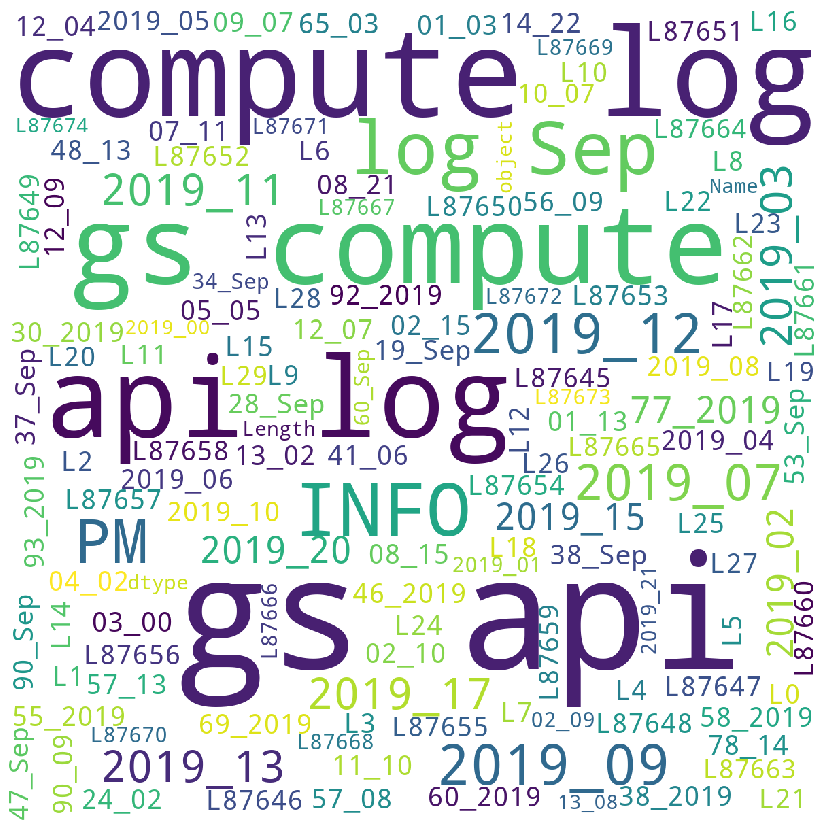

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 10000, random_state=42).generate(str(data[0]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [6]:
from keras.preprocessing.text import Tokenizer

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(list(data[0])+ list(data_test_public[0]))

Using TensorFlow backend.


In [7]:
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))


Found 91981 unique tokens.


### Text cleaning

<h3>Remove all stopwords,delimiters,hyphens,exclamation marks etc...</h3>

In [8]:
import re 
import nltk
#nltk.download('wordnet')

#### Preprocessing

In [9]:
def remove(list): 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list] 
    return list

In [10]:
def preprocess(data):
    import re 
    from textblob import Word
    import nltk
    print(data[0][0])
    data = data[0].apply(lambda x:[i.split('.')for i in x.strip().split()])
    print(data[0][0])

    data = data.apply(lambda x:[remove(i) for i in x])
    print(data[0][0])
    
    data = data.apply(lambda x:' '.join(j for i in x for j in i ))
    print(data[0][0])
    data = data.apply(lambda x: " ".join(x.lower() for x in x.split()))
    print(data[0][0])
    data =  data.str.replace('[^\w\s]','')
    print(data[0][0])

    remove_word = ['gs','lgs','log','info','_','__']
    print(data[0][0])

    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in remove_word))
    print(data[0][0])

    
    # nltk.download('wordnet')
    data = data.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    print(data[0][0])
    data = data.apply(lambda x:x.strip(x.split()[0]))
    print(data[0][0])
    
    return data

In [11]:
train1 = preprocess(data)

L0~gs.api.log.57_13-09-2019_06:59 34703 INFO gs.openstack.wsgi.server [ req-y9mjwk-n1yj-6wl35r-nhwlbg ] HTTP exception thrown: No entry found for any event
['L0~gs', 'api', 'log', '57_13-09-2019_06:59']
['L~gs', 'api', 'log', '_--_:']
L
l
l
l
a
a
 


In [12]:
test = preprocess(data_test_public)

L0~gs.api.log.69_Sep 14, 2019_13:20:00 58233 INFO gs.openapi.server [ req-qvrlz-kqijyd-easb2-l89bg-460fp ] [ instance: rq1a-vla0s-57sy1o ] vcpu limit not specified, default to unlimited
['L0~gs', 'api', 'log', '69_Sep']
['L~gs', 'api', 'log', '_Sep']
L
l
l
l
a
a
 


### Word2Vec

After experimenting a lot with TF-IDF approach, we will try the word2vec pretrained embedsdings

In [13]:
import gensim
import logging

In [14]:
import gzip
import gensim 
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [15]:
import nltk

documents = []
i=0
for line in train1: 
    i+=1
    if (i%10000==0):
      logging.info ("read {0} logs".format(i))
      # do some pre-processing and return a list of words for each tweet, basically doing tokenizing
    # documents.append(gensim.utils.simple_preprocess(line))
    documents.append(nltk.word_tokenize(line))

2020-08-12 20:26:46,851 : INFO : read 10000 logs
2020-08-12 20:26:47,912 : INFO : read 20000 logs
2020-08-12 20:26:48,967 : INFO : read 30000 logs
2020-08-12 20:26:50,022 : INFO : read 40000 logs
2020-08-12 20:26:51,096 : INFO : read 50000 logs
2020-08-12 20:26:52,155 : INFO : read 60000 logs
2020-08-12 20:26:53,233 : INFO : read 70000 logs
2020-08-12 20:26:54,301 : INFO : read 80000 logs


In [16]:
from gensim.models import Word2Vec
sentences = documents
# size option needs to be set to 300 to be the same as Google's pre-trained model
 
word2vec_model = Word2Vec(size = 300, window=5,
min_count = 1, workers = 10)

word2vec_model.build_vocab(sentences)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)

2020-08-12 20:27:11,601 : INFO : collecting all words and their counts
2020-08-12 20:27:11,605 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-12 20:27:11,635 : INFO : PROGRESS: at sentence #10000, processed 105783 words, keeping 1325 word types
2020-08-12 20:27:11,659 : INFO : PROGRESS: at sentence #20000, processed 211383 words, keeping 1710 word types
2020-08-12 20:27:11,690 : INFO : PROGRESS: at sentence #30000, processed 317134 words, keeping 1942 word types
2020-08-12 20:27:11,713 : INFO : PROGRESS: at sentence #40000, processed 423147 words, keeping 2334 word types
2020-08-12 20:27:11,736 : INFO : PROGRESS: at sentence #50000, processed 530089 words, keeping 2559 word types
2020-08-12 20:27:11,761 : INFO : PROGRESS: at sentence #60000, processed 636602 words, keeping 2645 word types
2020-08-12 20:27:11,793 : INFO : PROGRESS: at sentence #70000, processed 743306 words, keeping 2684 word types
2020-08-12 20:27:11,816 : INFO : PROGRESS: at sentenc

In [17]:
word2vec_model.train(sentences, total_examples=len(sentences), epochs = 10)

2020-08-12 20:28:43,193 : INFO : training model with 10 workers on 2711 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2020-08-12 20:28:44,665 : INFO : EPOCH 1 - PROGRESS: at 1.08% examples, 3305 words/s, in_qsize 18, out_qsize 1
2020-08-12 20:28:45,049 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-08-12 20:28:45,056 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-08-12 20:28:45,058 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-12 20:28:45,065 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-12 20:28:45,066 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-12 20:28:45,070 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-12 20:28:45,074 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-12 20:28:45,077 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-12 

(4274911, 9313320)

In [18]:
word2vec_model.wv.save_word2vec_format('trained_model.txt', binary=False)

2020-08-12 20:29:05,595 : INFO : storing 2711x300 projection weights into trained_model.txt


These embeddings need to be downloaded in your local machine, and then can be loaded to transform your document into numeric data

In [19]:
from gensim.models import Word2Vec
# pretrained model

wv = gensim.models.KeyedVectors.load_word2vec_format("trained_model.txt", binary=False)

# uncomment the model which u wish to use
wv.init_sims(replace=True)

2020-08-12 20:29:11,505 : INFO : loading projection weights from trained_model.txt
2020-08-12 20:29:12,202 : INFO : loaded (2711, 300) matrix from trained_model.txt
2020-08-12 20:29:12,203 : INFO : precomputing L2-norms of word weight vectors


In [20]:
#We use the averaging method here, basically converting all the words in a sentence into a vector and then 
#taking mean of all the vectors in a sentence, which will represent that sentence in a N-Dimensional numeric vector
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [21]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens


import nltk

train_w2v, test_w2v = train1, test


test_tokenized = test_w2v.apply(lambda r: w2v_tokenize_text(r)).values

train_tokenized = train_w2v.apply(lambda r: w2v_tokenize_text(r)).values



X_train_word_average = word_averaging_list(wv,train_tokenized)

X_test_word_average = word_averaging_list(wv,test_tokenized)



/home/vishal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  


### Model after FE

We do a little bit of Feature engineering here, we concat the PCA components of data to current feature matrix. This gave a significant increament on leaderboard

In [22]:
x_t = X_train_word_average
x_v = X_test_word_average
## these were the feature matrices we used before PCA Fature engineering


In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

pca_x = np.concatenate([x_t,pca.fit_transform(X_train_word_average)],axis=1)
pca_x_v = np.concatenate([x_v,pca.transform(X_test_word_average)],axis=1)
# X = pca.fit_transform(x_t_df)

### Final Model

#### K-Means Clustering

In [36]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=20,max_iter=150,init='k-means++')
km.fit(x_t)
#km.fit(pca_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=150,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [37]:
km.predict(x_t)
#km.predict(pca_x)
labels = km.labels_

In [38]:
km.inertia_

5172.627416994093

##### Lets save this model, for reproducibility of our results

In [0]:
# import pickle
# filename = 'best_model_9_40pm_latest_954.sav'
# pickle.dump(km, open(filename, 'wb'))

### Lets visualize this

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

X = pca.fit_transform(x_t)
# X = pca.fit_transform(x_t_df)

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Text(0.5, 0.92, 'K Means')

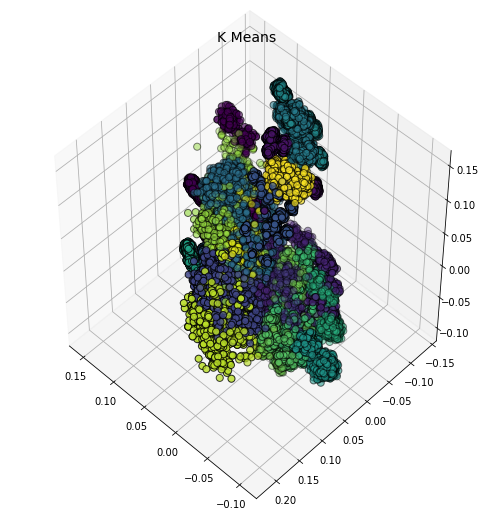

In [39]:
#Plotting
X=x_t
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter3D(X[:, 2], X[:, 0], X[:, 1],
          c=labels.astype(np.float), edgecolor="k", s=50)
plt.title("K Means", fontsize=14)

#### We do see some clusters, lets predict on test data

### Elbow Method - Execute these cells for param tuning

#### Current optimal params - 
1. k = 20
2. max_iter = 150

In [141]:
from sklearn import metrics 
from scipy.spatial.distance import cdist 

In [145]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(5,20) 
  
x = x_t

count=0
for k in K: 
             #     Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(x) 
    kmeanModel.fit(x)     

    distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / x.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / x.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

    count+=1
    print(count,'Models trained ..')

1 Models trained ..
2 Models trained ..
3 Models trained ..
4 Models trained ..
5 Models trained ..
6 Models trained ..
7 Models trained ..
8 Models trained ..
9 Models trained ..
10 Models trained ..
11 Models trained ..
12 Models trained ..
13 Models trained ..
14 Models trained ..
15 Models trained ..


5 : 0.4484196567541147
6 : 0.39397406497778364
7 : 0.35980289871447807
8 : 0.33655697003714635
9 : 0.3232450530318643
10 : 0.308303620992777
11 : 0.2956934810860625
12 : 0.28191662077015645
13 : 0.27761568855452323
14 : 0.2563584088565135
15 : 0.2525374104657613
16 : 0.2457606204204901
17 : 0.23110449540641184
18 : 0.22768169470492727
19 : 0.2250469134360215


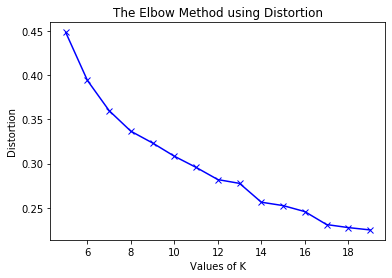

In [147]:
for key,val in mapping1.items(): 
     print(str(key)+' : '+str(val)) 

plt.plot([i for i in range(5,20)], distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

5 : 19264.348131843035
6 : 16018.288698006694
7 : 13970.074075457713
8 : 11799.070730670357
9 : 10619.965368198496
10 : 9741.580632058553
11 : 9124.587468421136
12 : 8210.053239705292
13 : 7818.354854754154
14 : 7099.839623427812
15 : 6821.774852563619
16 : 6295.402098395254
17 : 5951.665082296796
18 : 5611.815994792595
19 : 5436.494553670062


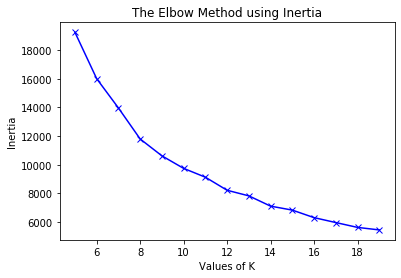

In [148]:
for key,val in mapping2.items(): 
     print(str(key)+' : '+str(val))
    
plt.plot([i for i in range(5,20)], inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 